| | |
|:----------|:----------|
| Name      | Bayesian Linear Regression |
| Author    | Joshuah Touyz, PhD |
| Version   | 1.0 |
|Last update| 02/13/20 |

### Linear regression using PyMC3

In [5]:

# Import PyMC3
from pymc3 import  *

# -- Load libraries --
# Data manipulation libraries
import numpy as np
from numpy.linalg import inv 
import scipy as sp
import pandas as pd

# Plotting libaries
import plotnine as pn
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt


# Supressing warnings
import warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("default")

#### Exercise
- Here you will be building a Poisson regression using the GLM function
- You will go through the same process as above with simulated data

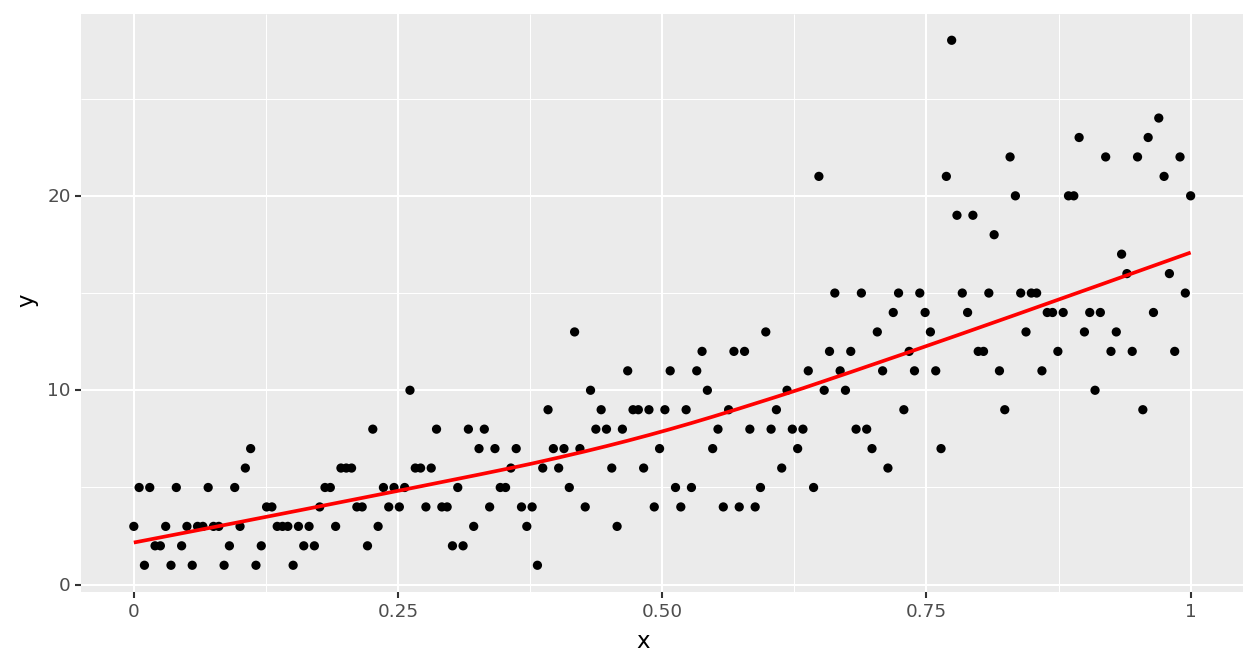

<ggplot: (339092523)>

In [83]:
# Plotting options
pn.options.figure_size=(10,5)
pn.options.dpi= 150

# True values
n = 200
beta_0 = 1
beta_1 = 2
x = np.linspace(0, 1, n)

# - Setting up the linear equation through the link function-
# Mean function
mu = beta_0 + beta_1 * x
# Lambda parameter
lam = np.exp(mu)

# Add noise
y = np.random.poisson(lam = lam, size=n)

# Setting up data
df_poisson = pd.DataFrame({'x':x,'y':y})

# True value
ggplot(aes(x = 'x',y = 'y'),data = df_poisson) + geom_point() +  geom_smooth(aes(x = 'x',y = 'y'),color='red', se=False)

#### Setting up the Poisson regression model

In [63]:
with Model() as model_poisson:

    # define priors, weakly informative Normal
    ______ = Normal('b0', mu=0, sigma=10)
    b1 = _________('b1', mu=0, sigma=10)

    # define linear model and exp link function
    mu = (b0 + ____ * df['x'])

    ## Define Poisson likelihood
    y = Poisson('y', mu=np.exp(___), observed=df_poisson['y'].values)
    
    trace_poisson = sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:01<00:00, 4422.70draws/s]
The acceptance probability does not match the target. It is 0.8876766025210284, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [76]:
# What are the HPD values?
summary_poisson = summary(trace_poisson, varnames=['______','b1'])
summary_poisson

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0,0.881,0.067,0.756,1.007,0.002,0.002,931.0,931.0,929.0,968.0,1.0
b1,2.129,0.093,1.956,2.301,0.003,0.002,946.0,945.0,943.0,1140.0,1.0


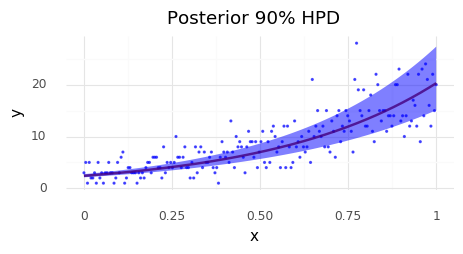

<ggplot: (337681377)>

In [85]:
pn.options.figure_size=(5,2)
pn.options.dpi= 100
# Finding the 95% posterior mean
lower_val_poisson =  np.exp(summary_poisson['hpd_3%'].b0 + ___________ *df_poisson['x'])
median_val_poisson =  np.exp(summary_poisson['mean'].b0 + summary_poisson['mean'].b1 *_____________)
upper_val_poisson =  np.exp(summary_poisson['hpd_97%'].__________ + summary_poisson['hpd_97%'].b1 * df_poisson['x'])
df_mean_ci_poisson = pd.DataFrame({'lower_val':lower_val_poisson,
                                   'median_val':median_val_poisson,
                                   'upper_val':upper_val_poisson,
                                   'y':df_poisson['y'], 'x':df_poisson['x']})

# Plotting the regression lines
ggplot(aes(x = 'x', y = 'y'), data = df_mean_ci_poisson)\
+ geom_point(size = 0.3, alpha = 0.6, color='blue')\
+ geom_line(aes(x = 'x',y = 'median_val'), alpha = 0.8, size = 1,color = 'darkred',data = df_mean_ci_poisson )\
+ theme_minimal() +ylab('y') + xlab('x')\
+ geom_ribbon(aes(x='x', ymin='lower_val',ymax='upper_val'), data=df_mean_ci_poisson, fill="blue", alpha=0.5)\
+ ggtitle('Posterior 90% HPD')

### Generating the posterior predictive

In [97]:
# Generating posterior samples
post_pred_poisson = sample_posterior_predictive(__________, samples=500, model=______________)
post_pred_dist_poisson = post_pred_poisson['y'].mean(axis=0)

# Getting the 95% credible interval
ci_95 = pd.DataFrame(post_pred_poisson['y']).quantile(q=[0.025,0.975], 
                                                      axis=0, 
                                                      numeric_only=True, interpolation='linear').T
ci_95 = ci_95.rename({0.025:'ci_lower', 0.975:'ci_upper'},axis=1)
ci_95['mean'] = post_pred_poisson['y'].mean(axis=0)
ci_95['x'] = df['x']
ci_95['y'] = df['y']


# Plotting the regression lines
ggplot(data = ci_95)\
+ geom_point(aes(x = 'x', y = 'y'), size = 0.3, alpha = 0.6, color='blue')\
+ theme_minimal() +ylab('y') + xlab('x')\
+ geom_line(aes(x = 'x', y = 'mean'), color='red')\
+ geom_ribbon(aes(x='x', ymin='ci_lower',ymax='ci_upper'), fill="blue", alpha=0.5)

100%|██████████| 500/500 [00:00<00:00, 1749.83it/s]


### Using the alternate method

In [71]:
# Alternate method using the GLM function
fml = 'y ~ x'  # Note the intercept is already included here
with Model() as model_poisson_2:

    glm.GLM.from_formula(fml, df_poisson, family=glm.families.Poisson())
    trace_poisson_2 = sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, x, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2860.28draws/s]
